In [155]:
# upload data
# libraries extraction
import glob 
import os 
import pandas as pd
import numpy as np 
from scipy.stats import ttest_ind 
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [156]:

df = pd.read_csv('C:/Users/Betty Reinhardova/Desktop/University/Thesis - Ms/data/data_thesis.csv')
df.head(3)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,...,revt,sale,seq,wcap,xrd,costat,mkvalt,gsector,sic,state
0,1004,31/05/2013,2012,INDL,C,D,STD,AIR,AAR CORP,USD,...,2167.1,2167.1,918.6,644.7,NaN,A,790.0029,20.0,5080,IL
1,1004,31/05/2014,2013,INDL,C,D,STD,AIR,AAR CORP,USD,...,2035.0,2035.0,999.5,714.8,NaN,A,961.3080,20.0,5080,IL
2,1004,31/05/2015,2014,INDL,C,D,STD,AIR,AAR CORP,USD,...,1594.3,1594.3,845.1,542.1,NaN,A,1046.3954,20.0,5080,IL


In [157]:
#creating unique ID
df['id'] = df.index + 1
df.head()
df['id'].count()

56013

In [158]:
#remove rows that do not have tic code
#filter out tic codes that are shorter than 4 or five letters = no special characters...
#remove sic in range of 4900-4999 (including)
#remove sic in range of 6000-6999 (including)
df['tic'] = df['tic'].astype("string")
df.dropna(subset=['tic'], inplace=True) 

df.dropna(subset=['sic'], inplace=True)
print(df['tic'].count())
print(df['tic'].str.len())

#FILTER TIC ONLY 4-5 LETTERS
#print(df.dtypes) 
#print(((df['tic'].str.len() ==5) | (df['tic'].str.len() ==4)).count())
#df.drop(df[(df['tic'].str.len() ==5) | (df['tic'].str.len() ==4)].index, inplace=True)

#print(df['tic'].str.match('[A-z]{4,5}'))

df[(df['tic'].str.match('[A-z]{4,5}'))]

df.drop(df[(df['sic'] >= 4900) & (df['sic'] <= 4999)].index, inplace=True)
df.drop(df[(df['sic'] >= 6000) & (df['sic'] <= 6999)].index, inplace=True)
df.drop(df[(df['fyear'] <=2012)].index, inplace=True)
df.drop(df[(df['at'] <=10)].index, inplace=True)
#df['id'].count()
df.drop(df.columns[[0,3,4,5,6,32]], axis=1, inplace=True)

df.shape[0]

55998
0        3
1        3
2        3
3        3
4        3
        ..
56008    4
56009    4
56010    4
56011    5
56012    5
Name: tic, Length: 55998, dtype: Int64


23458

In [159]:
#df['xrd'].fillna(0,inplace=True)
#df['at'].fillna(0,inplace=True)
# df['wcap'].fillna(0,inplace=True)
# df['ebit'].fillna(0,inplace=True)
# df['re'].fillna(0,inplace=True)
# df['sale'].fillna(0,inplace=True)
# df['derac'].fillna(0,inplace=True)
# df['deralt'].fillna(0,inplace=True)
# df['derlc'].fillna(0,inplace=True)
# df['derllt'].fillna(0,inplace=True)
# df['cidergl'].fillna(0,inplace=True)
# df['lt'].fillna(0,inplace=True)
# df.head(30)

In [160]:
df.dropna(subset=['xrd','at', 'wcap','re','ebit','sale','ebitda','mkvalt','lt', 'fyear'], inplace=True)

In [161]:
df['rd intensity'] = df['xrd'] / df['at']
#create new variable - R&D intensity = R&D expenditure / TA
df['Altman Z-score AD'] = (1.2 * df['wcap'] + 1.4 * df['re'] + 3.3 * df['ebit'] + 0.999 * df['sale'])/df['at']
#create new variable - Altman Z-score = (1.2 x WC + 1.4 x RE + 3.3 x EBIT + 0.999 x Sales)/TA -> score lower than 1.65 = risky business -> please check the range and go back to thesis page 26
df['hedging intensity'] = (df['derac'] + df['deralt'] + df['derlc']) + df['derllt'] / df['at']

df['Altman Z-score NA'] = ((1.2 * df['wcap'] + 1.4 * df['re'] + 3.3 * df['ebit'] + 1 * df['sale'])/df['at']) + (0.6 * (df['mkvalt']/df['lt']))
#not adjusted Altman-z

#df['hedging intensity'].fillna(0,inplace=True)
#df['rd intensity'].fillna(0,inplace=True)
#df['financial distress prob'].fillna(0,inplace=True)
#df[['rd intensity', 'hedging intensity']].replace(np.nan, 0)


df.head(10)
#df.dtypes


,datadate,fyear,tic,conm,curcd,fyr,at,cidergl,derac,deralt,...,xrd,mkvalt,gsector,sic,state,id,rd intensity,Altman Z-score AD,hedging intensity,Altman Z-score NA
49,31/12/2013,2013,ABT,ABBOTT LABORATORIES,USD,12,42953.000,-53.0,84.0,87.0,...,1452.000,59338.5963,35.0,3845,IL,50,0.033804,1.636490,751.000000,3.650069
50,31/12/2014,2014,ABT,ABBOTT LABORATORIES,USD,12,41275.000,94.0,257.0,101.0,...,1345.000,67891.7357,35.0,3845,IL,51,0.032586,1.466022,933.000000,3.541021
51,31/12/2015,2015,ABT,ABBOTT LABORATORIES,USD,12,41247.000,-35.0,179.0,116.0,...,1405.000,66137.3852,35.0,3845,IL,52,0.034063,1.556806,836.000000,3.549291
52,31/12/2016,2016,ABT,ABBOTT LABORATORIES,USD,12,52666.000,-15.0,276.0,8.0,...,1422.000,56572.8983,35.0,3845,IL,53,0.027000,1.567363,820.001405,2.630194
53,31/12/2017,2017,ABT,ABBOTT LABORATORIES,USD,12,76250.000,-134.0,138.0,0.0,...,2235.000,99507.3661,35.0,3845,IL,54,0.029311,1.037558,343.001220,2.360216
54,31/12/2018,2018,ABT,ABBOTT LABORATORIES,USD,12,67173.000,136.0,114.0,0.0,...,2300.000,126983.9223,35.0,3845,IL,55,0.034240,1.119382,209.001489,3.210050
55,31/12/2019,2019,ABT,ABBOTT LABORATORIES,USD,12,67887.000,-53.0,148.0,48.0,...,2440.000,153091.0106,35.0,3845,IL,56,0.035942,1.157909,285.000000,3.669028
70,31/12/2013,2013,ACU,ACME UNITED CORP,USD,12,68.079,0.0,NaN,NaN,...,0.603,47.6949,20.0,3420,CT,71,0.008857,3.034706,NaN,3.901261
71,31/12/2014,2014,ACU,ACME UNITED CORP,USD,12,79.308,0.0,NaN,NaN,...,0.665,65.7871,20.0,3420,CT,72,0.008385,2.875805,NaN,3.866933
72,31/12/2015,2015,ACU,ACME UNITED CORP,USD,12,81.421,0.0,NaN,NaN,...,0.690,58.2552,20.0,3420,CT,73,0.008474,2.962858,NaN,3.878325


In [162]:
#df['dummy hedge'] = pd.get_dummies(df['hedging intensity'])
dummy_hedge = df['hedge group'] = (df['hedging intensity'] > 0).astype(int)
#hedger = dummy_hedge==1
#nonhedger = dummy_hedge==0
#hedger = [df['hedge group'] == 1]
#nonhedger = [df['hedge group] == 0]
df.head(10)



,datadate,fyear,tic,conm,curcd,fyr,at,cidergl,derac,deralt,...,mkvalt,gsector,sic,state,id,rd intensity,Altman Z-score AD,hedging intensity,Altman Z-score NA,hedge group
49,31/12/2013,2013,ABT,ABBOTT LABORATORIES,USD,12,42953.000,-53.0,84.0,87.0,...,59338.5963,35.0,3845,IL,50,0.033804,1.636490,751.000000,3.650069,1
50,31/12/2014,2014,ABT,ABBOTT LABORATORIES,USD,12,41275.000,94.0,257.0,101.0,...,67891.7357,35.0,3845,IL,51,0.032586,1.466022,933.000000,3.541021,1
51,31/12/2015,2015,ABT,ABBOTT LABORATORIES,USD,12,41247.000,-35.0,179.0,116.0,...,66137.3852,35.0,3845,IL,52,0.034063,1.556806,836.000000,3.549291,1
52,31/12/2016,2016,ABT,ABBOTT LABORATORIES,USD,12,52666.000,-15.0,276.0,8.0,...,56572.8983,35.0,3845,IL,53,0.027000,1.567363,820.001405,2.630194,1
53,31/12/2017,2017,ABT,ABBOTT LABORATORIES,USD,12,76250.000,-134.0,138.0,0.0,...,99507.3661,35.0,3845,IL,54,0.029311,1.037558,343.001220,2.360216,1
54,31/12/2018,2018,ABT,ABBOTT LABORATORIES,USD,12,67173.000,136.0,114.0,0.0,...,126983.9223,35.0,3845,IL,55,0.034240,1.119382,209.001489,3.210050,1
55,31/12/2019,2019,ABT,ABBOTT LABORATORIES,USD,12,67887.000,-53.0,148.0,48.0,...,153091.0106,35.0,3845,IL,56,0.035942,1.157909,285.000000,3.669028,1
70,31/12/2013,2013,ACU,ACME UNITED CORP,USD,12,68.079,0.0,NaN,NaN,...,47.6949,20.0,3420,CT,71,0.008857,3.034706,NaN,3.901261,0
71,31/12/2014,2014,ACU,ACME UNITED CORP,USD,12,79.308,0.0,NaN,NaN,...,65.7871,20.0,3420,CT,72,0.008385,2.875805,NaN,3.866933,0
72,31/12/2015,2015,ACU,ACME UNITED CORP,USD,12,81.421,0.0,NaN,NaN,...,58.2552,20.0,3420,CT,73,0.008474,2.962858,NaN,3.878325,0


In [163]:
# CONTROL VARIABLES
df['size'] = np.log(df['at'])
# SIZE = natural log of bv assets
df['fp'] = df['ebitda'] / df['at'] 
# FP = EBITDA / TA
df['ast'] = df['ppent'] / df['at']
#AST = PP&E / TA 
df['mb'] = df['mkvalt']/ (df['at'] - df['lt']) 
# M/B = market value of equity+ book value of debt / TA   CHECK
df['leve'] = df['lt']
# Leve
df['sector'] = df['sic']
# SECTOR = fixed effect
df['time'] = df['fyear']
# TIME
df['defr'] = df['Altman Z-score AD']
# Def R = altman zcosre
# df['size'].fillna(0,inplace=True)
# df['fp'].fillna(0,inplace=True)
# df['ast'].fillna(0,inplace=True)
# df['mb'].fillna(0,inplace=True)
# df['leve'].fillna(0,inplace=True)
# df['defr'].fillna(0,inplace=True)
df.head(10), df.shape

(      datadate  fyear  tic                 conm curcd  fyr         at  \
 49  31/12/2013   2013  ABT  ABBOTT LABORATORIES   USD   12  42953.000   
 50  31/12/2014   2014  ABT  ABBOTT LABORATORIES   USD   12  41275.000   
 51  31/12/2015   2015  ABT  ABBOTT LABORATORIES   USD   12  41247.000   
 52  31/12/2016   2016  ABT  ABBOTT LABORATORIES   USD   12  52666.000   
 53  31/12/2017   2017  ABT  ABBOTT LABORATORIES   USD   12  76250.000   
 54  31/12/2018   2018  ABT  ABBOTT LABORATORIES   USD   12  67173.000   
 55  31/12/2019   2019  ABT  ABBOTT LABORATORIES   USD   12  67887.000   
 70  31/12/2013   2013  ACU     ACME UNITED CORP   USD   12     68.079   
 71  31/12/2014   2014  ACU     ACME UNITED CORP   USD   12     79.308   
 72  31/12/2015   2015  ACU     ACME UNITED CORP   USD   12     81.421   
 
     cidergl  derac  deralt  ...  Altman Z-score NA  hedge group       size  \
 49    -53.0   84.0    87.0  ...           3.650069            1  10.667862   
 50     94.0  257.0   101.

In [164]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['xrd','at', 'wcap','re','ebit','sale','ebitda','mkvalt','lt','hedging intensity','fyear','leve','mb','time','size','ast'], inplace=True)

In [165]:
# descriptive statistics -> ask if to get rid of outliers? bedause they are affecting means
from IPython.display import Image
descriptives_stat = np.round(df.describe(include='number'),2).transpose()[['count','mean','std','min','max']]
descriptives_stat.to_csv('descriptives_statistics.csv')
descriptives_stat.to_latex('summary stats.tex')
#Image(width=600, filename='Descriptives Statistics Table (LaTex).png')
descriptives_stat 

,count,mean,std,min,max
fyear,2121.0,2016.35,1.93,2013.00,2019.00
fyr,2121.0,10.19,3.31,1.00,12.00
at,2121.0,14672.16,36518.75,10.05,531864.00
cidergl,2101.0,-2.47,93.26,-2282.25,1105.08
derac,2121.0,33.59,150.90,0.00,4501.00
deralt,2121.0,24.11,103.44,-7.00,1396.10
derhedgl,1338.0,0.77,93.68,-654.00,1411.00
derlc,2121.0,30.41,150.41,0.00,4427.00
derllt,2121.0,34.61,238.37,-8.66,7967.00
dlc,2121.0,632.94,3139.40,0.00,54313.00


In [166]:
# df['rd intensity'].isnull().sum()
# df['mb'].isnull().sum()
# df['fp'].isnull().sum()
# df['financial distress prob'].isnull().sum()
# df['financial distress prob'].dtypes

In [167]:
sic_codes = df.groupby(['sic']).sum()
sic_codes.index
sic_codes['rd intensity']

sic
100     0.038604
1040    0.003703
1221    0.051628
1311    0.011652
1389    0.127614
          ...   
8071    0.038736
8090    0.000000
8700    0.074446
8711    0.007774
8742    0.233759
Name: rd intensity, Length: 186, dtype: float64

In [168]:
df['conm'].nunique()
#number of unique firms in the dataset

539

C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_3100\993444299.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sic_codes.index, rotation=0)


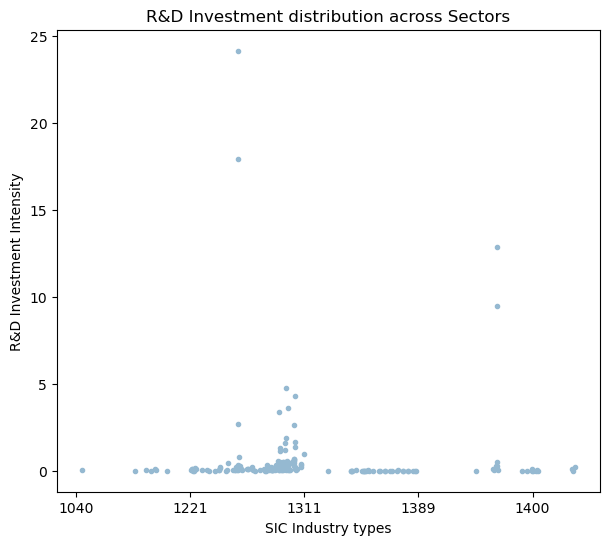

In [169]:
rd_investment = df['rd intensity']

# Create a bar chart
fig, ax = plt.subplots(figsize=(7,6))
# bar_chart = ax.bar(sic_codes.index, sic_codes['rd intensity'], color='#95b9d1')
bar_chart = ax.plot(sic_codes['rd intensity'], color='#95b9d1', marker='.',linestyle='none')

# Set chart title, labels, and rotation
ax.set_title('R&D Investment distribution across Sectors')
ax.set_ylabel('R&D Investment Intensity')
ax.set_xlabel('SIC Industry types')
ax.set_xticklabels(sic_codes.index, rotation=0)

# Display the chart
plt.show()
#ADJUST THE X AXIS

In [170]:
sorted_sic_codes = sic_codes.sort_values('rd intensity', ascending=False)
top_5_sic_codes = sorted_sic_codes['rd intensity'].head(5)
print(top_5_sic_codes)
#LOOKING AT THE TOP 5 SIC CODES WITH MOST R&D  

sic
2836    24.145695
2834    17.917948
7370    12.883199
7372     9.469667
3674     4.763361
Name: rd intensity, dtype: float64


In [171]:
median_rd_intensity = sic_codes['rd intensity'].median()
print(median_rd_intensity)
#we want to look if there are differences acorss above indistries in median or below median industries 

0.07489628580159914


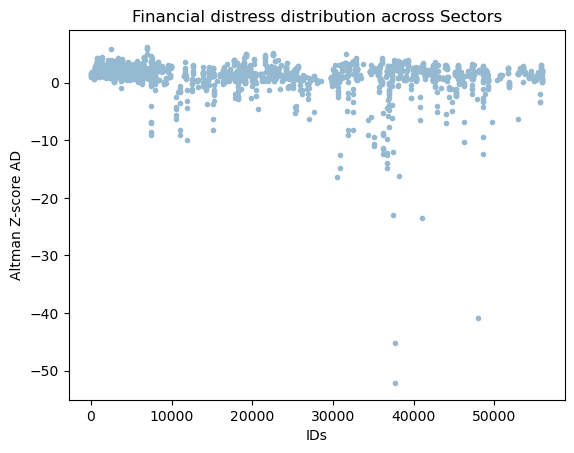

In [172]:
probability_fin_distress = df['Altman Z-score AD']

# Create a bar chart
fig, ax = plt.subplots()
bar_chart = ax.scatter(df['id'], df['Altman Z-score AD'], color='#95b9d1', marker='.')

# Set chart title, labels, and rotation
ax.set_title('Financial distress distribution across Sectors')
ax.set_ylabel('Altman Z-score AD')
ax.set_xlabel('IDs')
#ax.set_xticklabels(df['id'], rotation=0)

# Display the chart
plt.show()

In [173]:
#CO S TIM??? SUMA NEFUNGUJE A NEUKAZUJE MI TO
# crate two lines of how much do they have across time? 
#hedgers vs non hedgers and altman zscore



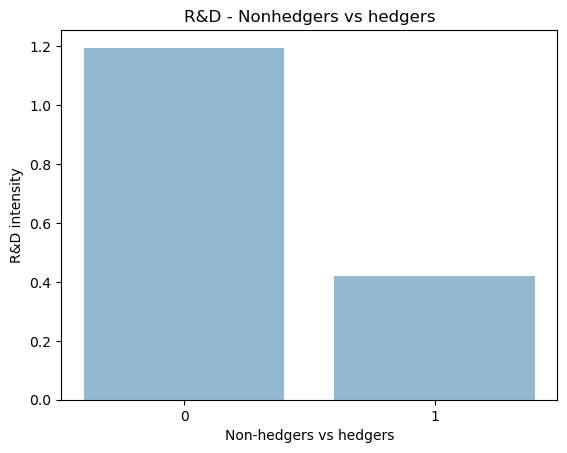

In [174]:
# Create a bar chart
fig, ax = plt.subplots()
bar_chart_hedgers_RD = ax.bar(df['hedge group'], rd_investment, color='#95b8d1')
#ZKUS TO ZNORMALIZOVAT MEZI 0-1

# Set chart title, labels, and rotation
ax.set_title('R&D - Nonhedgers vs hedgers')
ax.set_ylabel('R&D intensity')
ax.set_xlabel('Non-hedgers vs hedgers')
plt.xticks([0,1])

plt.show()

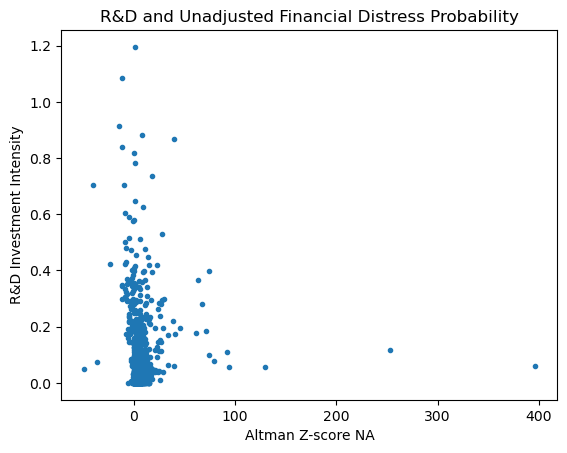

In [175]:
plt.scatter(df['Altman Z-score NA'], df['rd intensity'], marker='.')
plt.title('R&D and Unadjusted Financial Distress Probability')
plt.xlabel('Altman Z-score NA')
plt.ylabel('R&D Investment Intensity')
plt.show()
#jestli jde udelat posunout osu -> zacinat v nule a jit i na minusi
#also there must be postiive values too? is it possible to get 0 in the middle and see the movement more closely? 

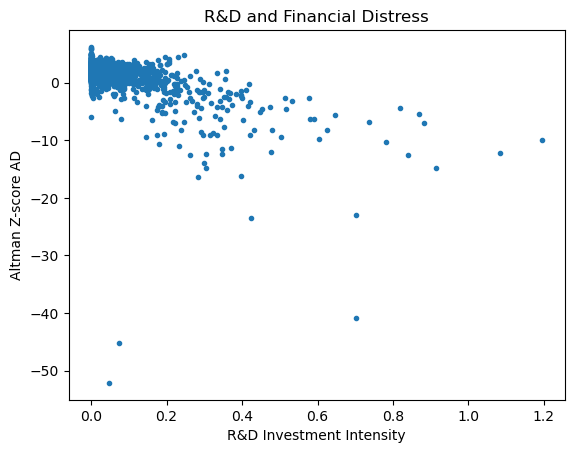

In [176]:
plt.scatter(df['rd intensity'], df['Altman Z-score AD'], marker='.')
plt.title('R&D and Financial Distress')
plt.xlabel('R&D Investment Intensity')
plt.ylabel('Altman Z-score AD')
plt.show()
#jestli jde udel

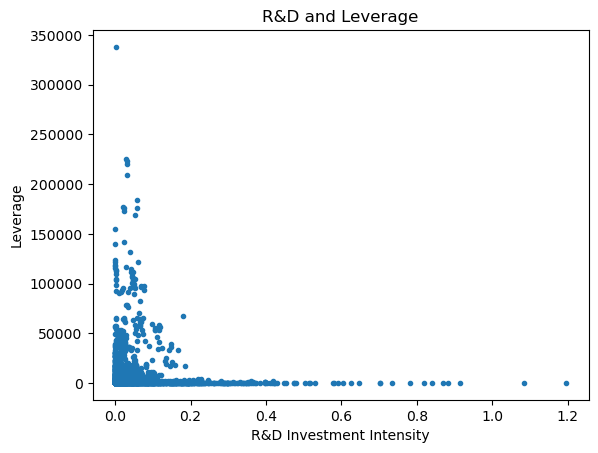

In [177]:
plt.scatter(df['rd intensity'], df['leve'], marker='.')
plt.title('R&D and Leverage')
plt.xlabel('R&D Investment Intensity')
plt.ylabel('Leverage')
plt.show()
#jestli jde udel

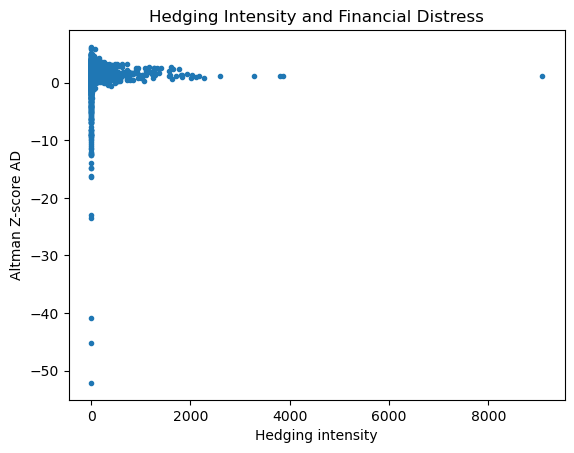

In [178]:
hedging_intensity = df['hedging intensity']
plt.scatter(df['hedging intensity'],df['Altman Z-score AD'],marker='.')
plt.title('Hedging Intensity and Financial Distress')
plt.xlabel('Hedging intensity')
plt.ylabel('Altman Z-score AD')
plt.show()

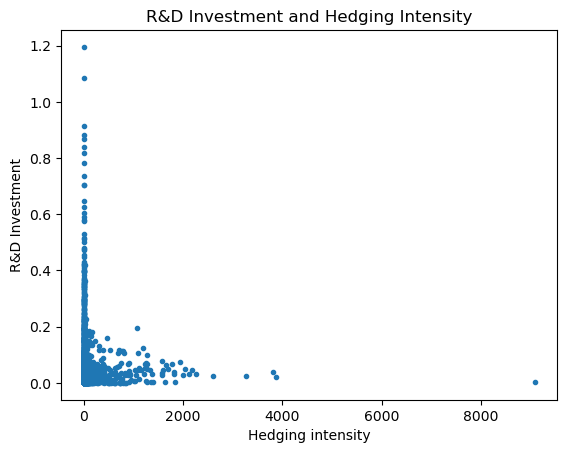

In [179]:
plt.scatter(df['hedging intensity'],df['rd intensity'],marker='.')
plt.title('R&D Investment and Hedging Intensity')
plt.xlabel('Hedging intensity')
plt.ylabel('R&D Investment')
plt.show()

In [180]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import statsmodels as stm 
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
import seaborn as sns
import scipy.stats as stats

In [181]:
#SUMMARY STATISTICS 1

# I need to lag all controls one year back because of the decision 
#df.groupby('hedge group')['financial distress prob'].describe(),2
statistics = df.groupby('hedge group')['Altman Z-score AD'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)
transposed_statistics = statistics.T
transposed_statistics.to_csv('statistics.csv')

In [182]:
#INDEPENDENT T-TEST 1 LOOKING FOR STATISTICAL SIGNIFICANCE
group_1 = df[df['hedge group']==1]
group_2 = df[df['hedge group']==0]
group_2.dropna(subset=['Altman Z-score AD'], inplace=True)
t_stat, p_value = ttest_ind(group_1['Altman Z-score AD'], group_2['Altman Z-score AD'], nan_policy= 'raise')

t_stat = round(t_stat,8)
p_value = round(p_value,100)

print('statistic:', t_stat, 'P-value:', p_value)

#HIGHLY SIGNIFICANT = YASS
#ttest1_paired = ttest_rel(hedger['financial distress prob'],nonhedger['financial distress prob'])

statistic: 14.62907842 P-value: 3.0456762596178685e-46


c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [183]:
group_2.dropna(subset=['Altman Z-score NA'], inplace=True)
ttest_ind(group_1['Altman Z-score NA'], group_2['Altman Z-score NA'], nan_policy= 'raise')

Ttest_indResult(statistic=-6.807556139352638, pvalue=1.2880660601385358e-11)

In [184]:
#SUMMARY STATISTICS 2
statistics_2 = df.groupby('hedge group')['rd intensity'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)
transposed_statistics_2 = statistics_2.T
transposed_statistics_2.to_csv('statistics_2.csv')

In [185]:
#INDEPENDENT T-TEST 2 
ttest_ind(group_1['rd intensity'], group_2['rd intensity'])

Ttest_indResult(statistic=-17.56258553478796, pvalue=1.4304956606634945e-64)

In [186]:
df.isin([np.inf,-np.inf]).values.sum()
#nejsou infity

0

In [187]:
from linearmodels.iv import IV2SLS
from linearmodels.panel import compare
from linearmodels import PanelOLS 

# Y = df['Altman Z-score AD']
# X = df['hedging intensity']
# Z = df[['leve', 'sic', 'size']]

# dat = sm.datasets.get_rdataset

# # Specify the formula for the IV2SLS model with instruments
# formula_iv = "'Altman Z-score AD' ~ 'hedging intensity' + [leve + size]"

# # Fit the IV2SLS model
# model_iv = IV2SLS.from_formula(formula_iv, data=df)
# results_iv = model_iv.fit()
# print(results_iv.params)

# # Fit the OLS model
# formula_ols = "'Altman Z-score AD' ~ 'hedging intensity' + 'leve' + 'size'"
# model_ols = IV2SLS.from_formula(formula_ols, data=df)
# results_ols = model_ols.fit()
# print(results_ols.params)

# # Perform the Hausman test using the compare function
# hausman_results = compare({'IV': results_iv, 'OLS': results_ols})

# print("Hausman Test Results:")
# print(hausman_results)

In [188]:
df[['leve','Altman Z-score AD', 'size', 'hedging intensity']].isin([np.nan]).values.sum()

0

In [189]:
from IPython.display import HTML

y_var = df['Altman Z-score AD']
x_var_hi = df[['hedging intensity','leve', 'hedge group']]
x_var_hi = sm.add_constant(x_var_hi)

x_var = df[['hedging intensity','hedge group','leve', 'time','sector','mb', 'size']]
x_var = sm.add_constant(x_var)

x_var_all = df[['hedging intensity', 'hedge group','leve', 'time','sector','mb', 'size','ast', 'fp']]
x_var_all = sm.add_constant(x_var_all)

pooled_olsr_mode = sm.OLS(endog=y_var,exog=x_var_hi)
pooled_olsr_mode_result = pooled_olsr_mode.fit()

pooled_olsr_mode_1 = sm.OLS(endog=y_var,exog=x_var)
pooled_olsr_mode_1_result = pooled_olsr_mode_1.fit()

pooled_olsr_mode_2 = sm.OLS(endog=y_var,exog=x_var_all)
pooled_olsr_mode_2_results = pooled_olsr_mode_2.fit()

#print(pooled_olsr_mode_result.summary())
#MAYBE ADD EBITDA? 
#stargazer = Stargazer([pooled_olsr_mode_result, pooled_olsr_mode_1_result, pooled_olsr_mode_2_results])
#HTML(stargazer.render_html())


#html_output = stargazer.render_html()

with open('output.html', 'w') as f:
    f.write(pooled_olsr_mode_result.summary().as_html())
    f.write(pooled_olsr_mode_1_result.summary().as_html())
    f.write(pooled_olsr_mode_2_results.summary().as_html())
#have to go to html conventer to change the html code to put constant as the first in the table :) 

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [190]:
y_var_2 = df['rd intensity']

x_var_2 = df[['Altman Z-score AD','hedging intensity','hedge group']]
var_interaction = df['Altman Z-score AD'] * df['hedging intensity']
x_var_2['interaction Z x HI'] = var_interaction
x_var_2 = sm.add_constant(x_var_2)

x_var_2_more = df[['Altman Z-score AD','hedging intensity', 'hedge group','leve', 'time','sector','fp', 'ast', 'size', 'mb','Altman Z-score NA']]
x_var_2_more['interaction Z x HI'] = var_interaction
x_var_2_more = sm.add_constant(x_var_2_more)

pooled_olsr_model = sm.OLS(endog=y_var_2,exog=x_var_2)
pooled_olsr_model_result = pooled_olsr_model.fit()

pooled_olsr_model_2 = sm.OLS(endog= y_var_2, exog=x_var_2_more)
pooled_olsr_model_2_result = pooled_olsr_model_2.fit()

#print(pooled_olsr_model_result.summary())

#stargazer_2 = Stargazer([pooled_olsr_model_result, pooled_olsr_model_2_result])

#html_output_2 = stargazer_2.render_html()
with open('output2.html', 'w') as f:
    f.write(pooled_olsr_model_result.summary().as_html())
    f.write(pooled_olsr_model_2_result.summary().as_html())
#have to go to html conventer to change the html code to put constant as the first in the table :) 



C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_3100\2386192387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_2['interaction Z x HI'] = var_interaction
c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_3100\2386192387.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [191]:
#ROBUSTNESS -> SUBSAMPLE 
#uniq = df['sic'].unique()
#unique_values_df = pd.DataFrame(uniq, columns=['sic'])
#unique_values_df.to_csv('unique_sic_values.csv', index=False)
df['sic'].dtypes
df['sic_group'] = df['sic'].astype(str).str[:2].astype(int)
#grouped_sic = df.groupby('sic_group')
uniq = df['sic_group'].unique()
unique_values_df = pd.DataFrame(uniq, columns=['sic_group_new'])
#unique_values_df.to_csv('unique_sic_values.csv', index=False)
#sic codes are extracted to csv and manually matched with division based on United States Department of Labor data - website can be found in references



In [192]:
division_b = [10,12,13,14]
division_c = [16]
division_d = [38,28,34,20,26,37,39,35,33,36,29,30,25,32,21,24,22,31,27,23]
division_e = [48,44]
division_f = [50,51]
division_g = [57,54,56,53,58,59,55,52]
division_i = [73,70,87,80,79,78]
def assign_division(divisions,letter):
    df.loc[df['sic_group'].isin(divisions),'division'] = letter

assign_division(division_b,'B')
assign_division(division_c, 'C')
assign_division(division_d, 'D')
assign_division(division_e, 'E')
assign_division(division_f, 'F')
assign_division(division_g, 'G')
assign_division(division_i, 'I')
df.head(1)

,datadate,fyear,tic,conm,curcd,fyr,at,cidergl,derac,deralt,...,size,fp,ast,mb,leve,sector,time,defr,sic_group,division
49,31/12/2013,2013,ABT,ABBOTT LABORATORIES,USD,12,42953.0,-53.0,84.0,87.0,...,10.667862,0.102275,0.137476,2.348462,17686.0,3845,2013,1.63649,38,D


In [193]:
df[['leve','Altman Z-score AD', 'size', 'hedging intensity','hedge group','ast','mb','fp','leve','time','Altman Z-score NA']].isin([np.nan]).values.sum()
df[['leve','Altman Z-score AD', 'size', 'hedging intensity','hedge group','ast','mb','fp','leve','time','Altman Z-score NA']].isin([np.isinf]).values.sum()

0

In [196]:
robustness_regression_results = []
#list with results 
divisions = ['B','C','D','E','F','G','I']
#unique sic_codes 
for division in divisions:
    subset_df = df[df['division'] == division]
    yvariable = subset_df['rd intensity']
    xvariable = subset_df[['Altman Z-score AD','hedging intensity', 'hedge group','leve', 'time','fp', 'ast', 'size', 'mb','Altman Z-score NA']]
    xvariable['interaction Z x HI'] = var_interaction
    xvariable = sm.add_constant(xvariable)

    pooledmodel = sm.OLS(endog=yvariable,exog=xvariable)
    robust_results = pooledmodel.fit()
    robustness_regression_results.append(robust_results)

for division, results in zip(divisions, robustness_regression_results):
    print(f'Regression Results for Division {division}:')
    print(results.summary().as_html())
    print('--------------------------------')
#stargazer_3 = Stargazer(robustness_regression_results)
#html_output_3 = stargazer_3.render_html()

with open('output3.html', 'w') as f:
    for division, results in zip(divisions, robustness_regression_results):
        f.write(f'<div class=\"division\">Regression Results for Division {division}<div/>')
        f.write(results.summary().as_html())



C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_3100\1189065824.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvariable['interaction Z x HI'] = var_interaction
c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\statsmodels\regression\linear_mo

Regression Results for Division B:
<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>      <td>rd intensity</td>   <th>  R-squared:         </th> <td>   0.672</td>
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.533</td>
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   4.846</td>
</tr>
<tr>
  <th>Date:</th>             <td>Wed, 21 Jun 2023</td> <th>  Prob (F-statistic):</th> <td>0.000457</td>
</tr>
<tr>
  <th>Time:</th>                 <td>21:16:34</td>     <th>  Log-Likelihood:    </th> <td>  156.10</td>
</tr>
<tr>
  <th>No. Observations:</th>      <td>    38</td>      <th>  AIC:               </th> <td>  -288.2</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>    26</td>      <th>  BIC:               </th> <td>  -268.5</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>    11</td>      <th>                     </th>

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
